In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
# Add the project directory to the Python path
project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)

from p2p_lending.constants import random_state_for_split, over_sampling_ratio

files = ["probas","targets","aleatoric_log_variances","epistemic_variances"]
eval_name="Test"

def load_data(path:str) -> dict[str,np.ndarray]:
    data:dict[str,np.ndarray] = {}
    for file in files:
        data[file] = np.load(os.path.join(path,file+f"_{eval_name}_{random_state_for_split}_{over_sampling_ratio}.npy"))
    return data

data = load_data("results/")

probas = data["probas"]
targets = data["targets"]
aleatoric_log_variances = data["aleatoric_log_variances"]
epistemic_variances = data["epistemic_variances"]
aleatoric_std = np.exp(0.5*aleatoric_log_variances)
epistemic_std = np.sqrt(epistemic_variances)
total_std= np.sqrt(aleatoric_std**2 + epistemic_std**2)
print(f"Loaded results of run '{eval_name}' with random state {random_state_for_split} and over sampling ratio {over_sampling_ratio}")

Loaded results of run 'Test' with random state 3213 and over sampling ratio 0.5


In [2]:
def _plot_probas_distr(probas):
    plt.hist(probas,bins=100)
    plt.title("Probas distribution")
    plt.show()

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
def _plot_auc_curve(probas_list,targets_list):

    for probas,targets in zip(probas_list,targets_list):
        fpr, tpr, _ = roc_curve(targets, probas)
        auc = roc_auc_score(targets, probas)
        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [4]:
def _plot_uncertainty_vs_error(uncertainty, error, title:str):
    plt.scatter(uncertainty, error, alpha=0.8, s=3)
    plt.xlabel(title)
    plt.ylabel("Error")
    plt.title(f"{title} vs Error")
    plt.show()

In [5]:
from scipy.interpolate import make_interp_spline
def _plot_uncertainty_bars_vs_missclassification(uncertainty, probas, targets, title:str):
    preds = probas > 0.5
        
    # Calculate the number of bins
    num_bins = 100

    # Create an array of bin edges
    bin_edges = np.linspace(np.min(uncertainty), np.max(uncertainty), num_bins + 1)

    # Create an array to store the counts of correct and incorrect predictions for each bin
    correct_counts = np.zeros(num_bins)
    incorrect_counts = np.zeros(num_bins)

    # Iterate over the uncertainty values and corresponding predictions
    for u, pred, target in zip(uncertainty, preds, targets):
        # Find the bin index for the current uncertainty value
        bin_index = np.searchsorted(bin_edges, u) - 1
        
        # Increment the count of correct or incorrect predictions based on the target and prediction values
        if pred == target:
            correct_counts[bin_index] += 1
        else:
            incorrect_counts[bin_index] += 1

    # Calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram with blue and red bars
    bar_width = bin_edges[1] - bin_edges[0]

    plt.bar(bin_centers, correct_counts, color='blue', alpha=0.5, label='Correct', width=bar_width)
    plt.bar(bin_centers, incorrect_counts, bottom=correct_counts, color='red', alpha=0.5, label='Incorrect', width=bar_width)
    plt.xlabel('Uncertainty')
    plt.ylabel('Count')
    plt.legend()
    
   
    ratio = correct_counts / (correct_counts + incorrect_counts)

    # Iterate over the invalid indices
    for i in range(1, len(ratio)):
        if np.isinf(ratio[i]) or np.isnan(ratio[i]):
            ratio[i] = ratio[i-1]
        
    # Create a twin Axes object
    ax2 = plt.twinx()

    # Plot the smoothed curve
    ax2.plot(bin_centers, ratio, color='green')

    # Set the label for the right y-axis
    ax2.set_ylabel('Ratio')
    
    # Add labels and title
    plt.title(title)

    # Show the plot
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def _plot_auc_over_quantiles(probas, targets, uncertainty, title,curve=False):
    auc_values = []
    thresholds = np.arange(1,0, -0.1)
    quantiles = np.quantile(uncertainty, thresholds)
    for quantile,threshold in zip(quantiles,thresholds):
        filtered_indices = np.where(uncertainty <= quantile)
        filtered_targets = targets[filtered_indices]
        filtered_probas = probas[filtered_indices]
        
        # Check if both classes are present
        if len(np.unique(filtered_targets)) < 2:
            print(f"Skipping quantile {quantile}: only one class present in targets.")
            continue
        
        if curve:
            fpr, tpr, _ = roc_curve(filtered_targets, filtered_probas)
            plt.plot(fpr, tpr, label=f"Quantile {threshold:.1f}")
        else:
            auc = roc_auc_score(filtered_targets, filtered_probas)
            auc_values.append(auc)
    
    if curve:
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {title}")
        plt.legend()
    else:
        plt.xticks(thresholds)
        plt.plot(thresholds, auc_values,marker='o', linestyle='-')
        plt.gca().invert_xaxis()  # Invert the x-axis

        plt.xlabel('Percentage of data kept')
        plt.ylabel('AUC')
        plt.title(f'Area under the ROC curve for different quantiles of {title}')
    plt.show()

In [7]:
from sklearn.metrics import accuracy_score


def _plot_acc_over_quantiles_per_class(probas, targets, uncertainty,title):
    positive_class_indexes = np.where(targets == 1)[0]
    negative_class_indexes = np.where(targets == 0)[0]
    thresholds = np.arange(1,0, -0.1)
    
    probas_positive = probas[positive_class_indexes]
    uncertainty_positive = uncertainty[positive_class_indexes]
    
    probas_negative = probas[negative_class_indexes]
    uncertainty_negative = uncertainty[negative_class_indexes]
    
    acc_values_positive = []
    acc_values_negative = []
    quantiles_positive = np.quantile(uncertainty_positive, thresholds)
    quantiles_negative = np.quantile(uncertainty_negative, thresholds)
    
    for quantile in quantiles_positive:
        filtered_indices = np.where(uncertainty_positive <= quantile)
        filtered_probas = probas_positive[filtered_indices]
        
        acc = accuracy_score(np.ones_like(filtered_probas), filtered_probas > 0.5)
        acc_values_positive.append(acc)
        
    for quantile in quantiles_negative:
        filtered_indices = np.where(uncertainty_negative <= quantile)
        filtered_probas = probas_negative[filtered_indices]
        
        acc = accuracy_score(np.zeros_like(filtered_probas), filtered_probas > 0.5)
        acc_values_negative.append(acc)
        
    plt.xticks(thresholds)
    plt.plot(thresholds, acc_values_positive,marker='o', linestyle='-', label="Positive class")
    plt.plot(thresholds, acc_values_negative,marker='o', linestyle='-', label="Negative class")
    plt.gca().invert_xaxis()  # Invert the x-axis
    
    plt.xlabel('Proportion of most confident predictions kept')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for different quantiles of {title} per class')
    plt.legend()
    plt.show()
    
    

In [8]:
def plot_uncertainty_distributions_per_class(uncertainty,title):
    mean_uncertainty_positive = np.mean(uncertainty[targets == 1])
    mean_uncertainty_negative = np.mean(uncertainty[targets == 0])

    plt.hist(uncertainty[targets == 1], bins=100, alpha=0.5, label="Positive class")
    plt.hist(uncertainty[targets == 0], bins=100, alpha=0.5, label="Negative class")
    plt.axvline(mean_uncertainty_positive, color='blue', linestyle='dashed', linewidth=1,label=f"Pos. mean: {mean_uncertainty_positive:.2f}")
    
    plt.axvline(mean_uncertainty_negative, color='orange', linestyle='dashed', linewidth=1,label=f"Neg. mean: {mean_uncertainty_negative:.2f}")
    plt.xlabel(title)
    plt.ylabel("Frequency")
    plt.title(f"{title} distribution per class")
    plt.legend()
    plt.show()

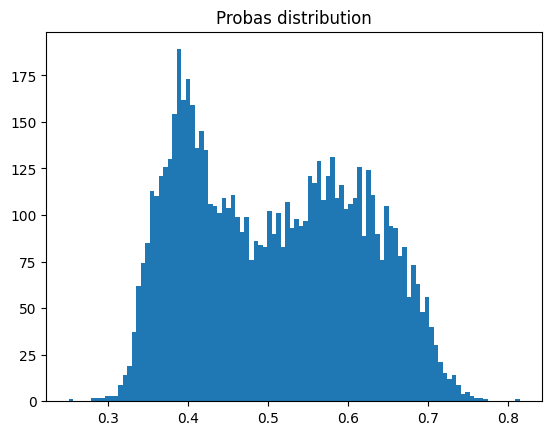

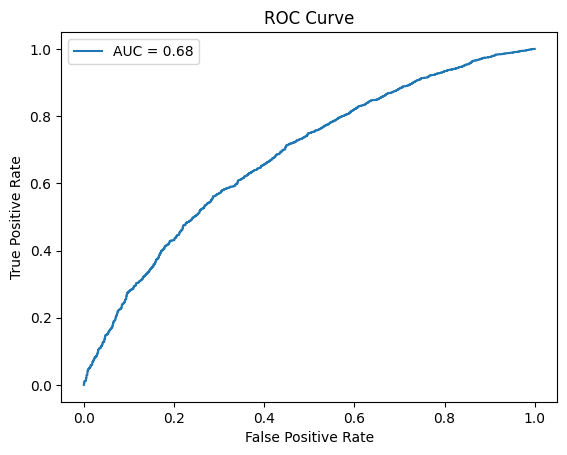

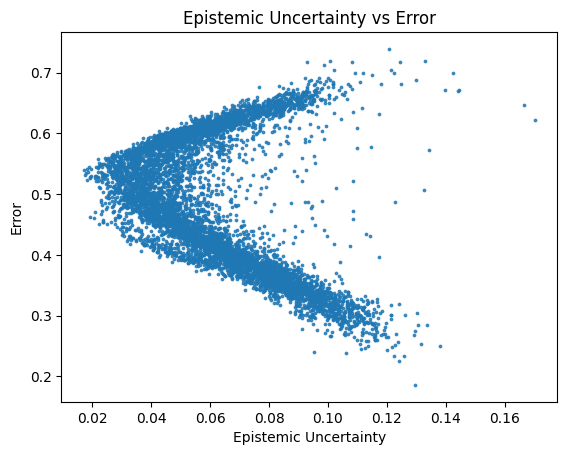

C:\Users\Jonah\AppData\Local\Temp\ipykernel_25588\1494839295.py:39: RuntimeWarning: invalid value encountered in divide
  ratio = correct_counts / (correct_counts + incorrect_counts)


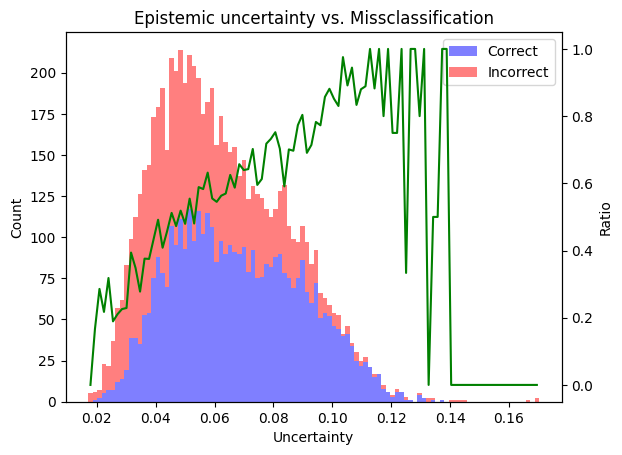

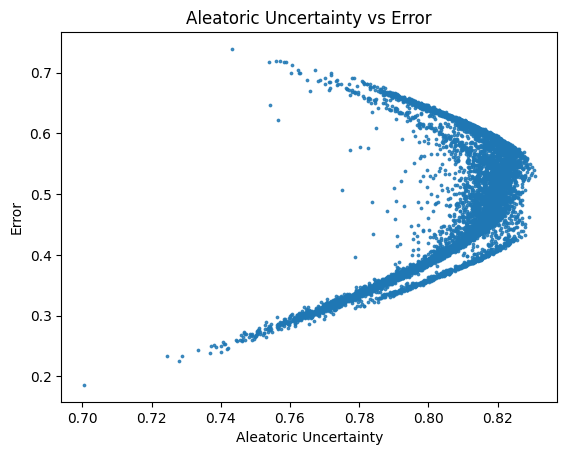

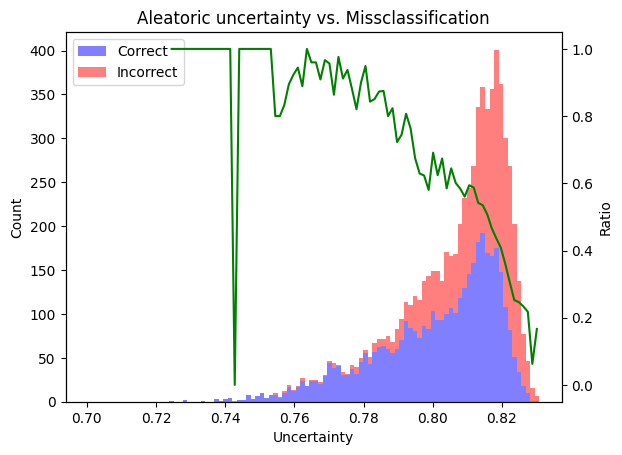

In [9]:
_plot_probas_distr(probas)
_plot_auc_curve([probas],[targets])
_plot_uncertainty_vs_error(epistemic_std, np.abs(probas-targets), "Epistemic Uncertainty")
_plot_uncertainty_bars_vs_missclassification(epistemic_std, probas, targets, title="Epistemic uncertainty vs. Missclassification")

_plot_uncertainty_vs_error(aleatoric_std, np.abs(probas-targets), "Aleatoric Uncertainty")
_plot_uncertainty_bars_vs_missclassification(aleatoric_std, probas, targets, title="Aleatoric uncertainty vs. Missclassification")


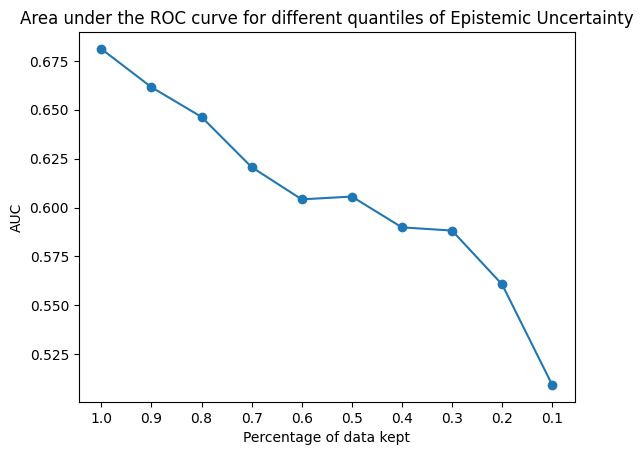

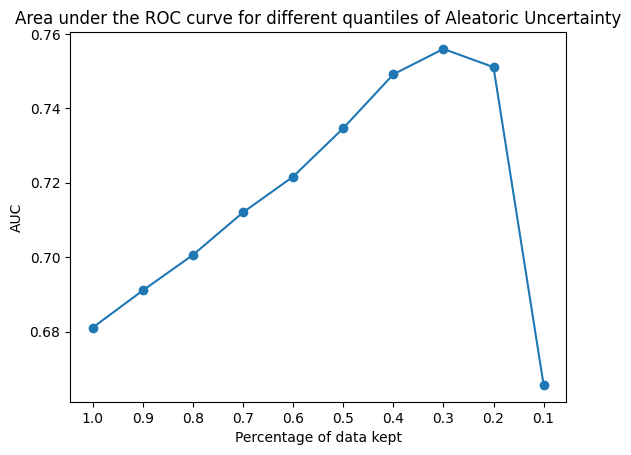

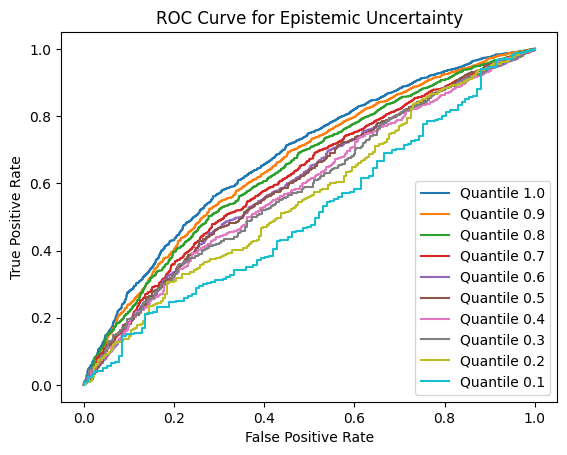

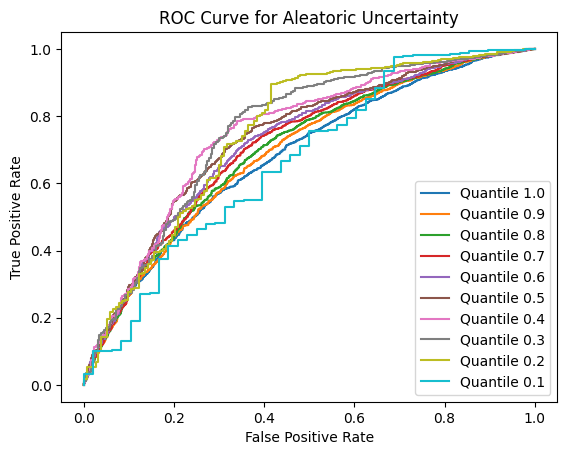

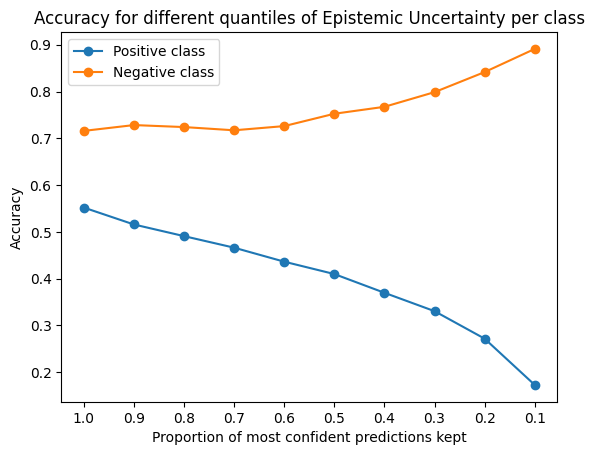

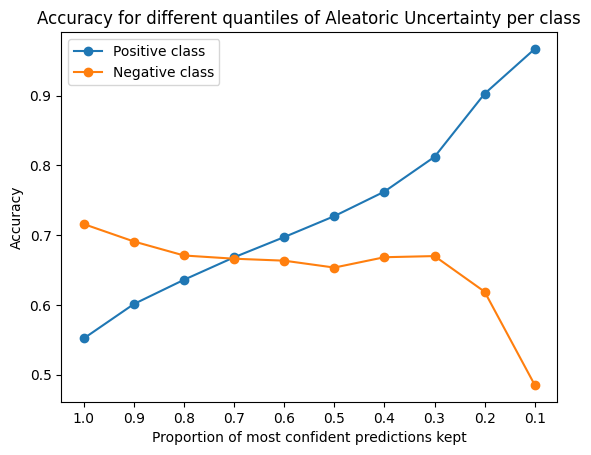

In [10]:
_plot_auc_over_quantiles(probas, targets, epistemic_std, title="Epistemic Uncertainty")
_plot_auc_over_quantiles(probas, targets, aleatoric_std, title="Aleatoric Uncertainty")
_plot_auc_over_quantiles(probas, targets, epistemic_std, title="Epistemic Uncertainty", curve=True)
_plot_auc_over_quantiles(probas, targets, aleatoric_std, title="Aleatoric Uncertainty", curve=True)
_plot_acc_over_quantiles_per_class(probas, targets, epistemic_std, title="Epistemic Uncertainty")
_plot_acc_over_quantiles_per_class(probas, targets, aleatoric_std, title="Aleatoric Uncertainty")

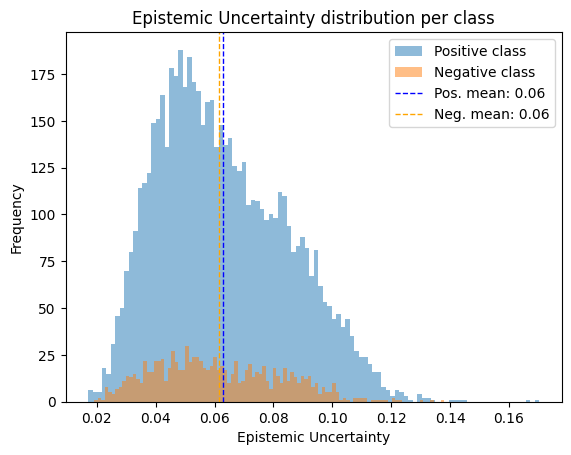

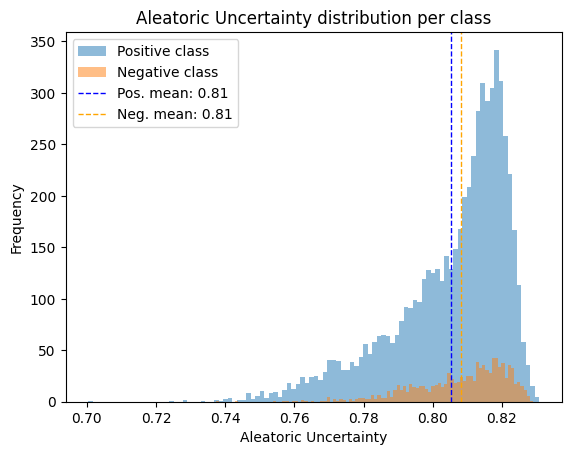

In [11]:
plot_uncertainty_distributions_per_class(epistemic_std, title="Epistemic Uncertainty")
plot_uncertainty_distributions_per_class(aleatoric_std, title="Aleatoric Uncertainty")